# Часть 2 ДЗ [3 балла] Реализация обучения модели diffusion С ПОМОЩЬЮ API Hugging Face

- Часть 1.1 ДЗ по [ссылке](https://github.com/shakhovak/Study-projects-in-Uni/blob/master/Diffusion_models_beginner/P1.1_HW1_Diffusion_model_simplified.ipynb)
- Часть 1.2 ДЗ по [ссылке](https://github.com/shakhovak/Study-projects-in-Uni/blob/master/Diffusion_models_beginner/P1_2_HW1_Diffusion_HF_API_standard.ipynb)
- Часть 3 ДЗ по [ссылке](https://github.com/shakhovak/Study-projects-in-Uni/blob/master/Diffusion_models_beginner/P3_HW1_Schedulers_inference_steps_comparison.ipynb)

Для того, чтобы из кода обучения Diffusion получить обучения Latent Diffusion, вам нужно добавить VQ-VAE и заморозить! и обрабатывать изображения с помощью vae.encode. Далее полученные latent, подаются в стандартный пайплайн обучения. Учтите, что latent имеет меньшую размерность и вам может понадобиться уменьшить число слоёв в архитектуре UNet.

В качестве модели VQ-VAE вы можете воспользоваться предобученным VQ-VAE от Stable diffusion.

**Ожидаемый результат**:

В качестве результатов модели, от вас требуется предоставить визуализации генераций, полученных от вашей модели, и код обучения модели

# План решения

Для решения я воспользуюсь небольшим датасетом с дизайнерскими худи от Martin Valen https://martinvalen.com/ru/
Возьму готовую Stable Diffusion Model и попробую ее дообучить для генерации похожих дизайнов. Буду пользоваться готовой моделью https://huggingface.co/CompVis/stable-diffusion-v1-4
Если обучать Unet с нуля, то она не даст таких результатов.

Inspiration from:
- https://www.youtube.com/watch?v=t2lcxvsqLWA&list=WL&index=3
- https://www.youtube.com/watch?v=ZBKpAp_6TGI&list=WL&index=4
- https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image.py




## 1. Загрузим датасет и преобразуем

In [196]:
#!g2.1
import glob
file_list_transformed = glob.glob("martin_valen/*")

In [197]:
#!g2.1
import PIL
from PIL import Image
image_list = []
for indx, file in enumerate(file_list_transformed):
    im = Image.open(file)
    #im = PIL.JpegImagePlugin.JpegImageFile(file)
    image_list.append(im)

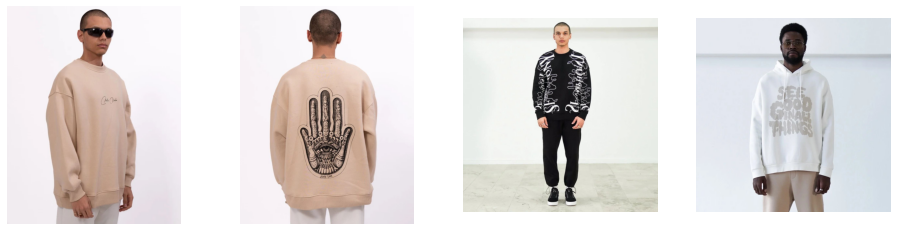

In [198]:
#!g2.1
import matplotlib.pyplot as plt
import random
num_samples = 4
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(num_samples):
    random_index = random.choice(range(len(image_list)))
    axs[i].imshow(image_list[random_index])
    axs[i].set_axis_off()

In [199]:
#!g2.1
path = 'CompVis/stable-diffusion-v1-4'

In [200]:
#!g2.1
%pip install diffusers["torch"] transformers

Defaulting to user installation because normal site-packages is not writeable
  Using cached charset_normalizer-2.0.12-py3-none-any.whl (39 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 2.1.0 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 2.1.0 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [201]:
#!g2.1
from transformers import CLIPTokenizer
tokenizer = CLIPTokenizer.from_pretrained(path, subfolder="tokenizer")

In [202]:
#!g2.1
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    image_size = 512  # the generated image resolution
    train_batch_size = 1
    #eval_batch_size = 4  # how many images to sample during evaluation
    num_train_epochs = 1
    gradient_accumulation_steps = 10
    
    max_train_steps = 1050
    learning_rate = 1e-4
    lr_warmup_steps = 600
    #save_image_epochs = 10
    #save_model_epochs = 30
    mixed_precision = "no"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 3


config = TrainingConfig()

In [203]:
#!g2.1
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

data_transforms = [
    transforms.Resize((config.image_size, config.image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
]
data_transform = transforms.Compose(data_transforms)

In [204]:
#!g2.1
from torch.utils.data import Dataset

class AdditionDataset(Dataset):
    """
        """

    def __init__(self, images):
        self.images = images
   
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        
        tokens = tokenizer('matrin valen', max_length=MAX_PROMPT_LENGTH, padding = 'max_length',
                      truncation=True, return_tensors="pt",)
        images = data_transform(self.images[index].convert("RGB"))
            
                                
        return {"pixel_values": images, 'input_ids':tokens.input_ids[0]}

Основные преобразования в датасете в рамках создания класса Dataset:

1. Изменение размера изображения
2. Поворот изоражения по горизонтали
3. Перевод в тензоры
4. Токенизация текста, создание эмбедингов и перевод в тензоры
5. Создание DataLoader

Далее вернем и текст и описание в начальное состояние, чтобы проверить, что все получилось.


In [205]:
#!g2.1
MAX_PROMPT_LENGTH = 15
dataset = AdditionDataset(image_list)

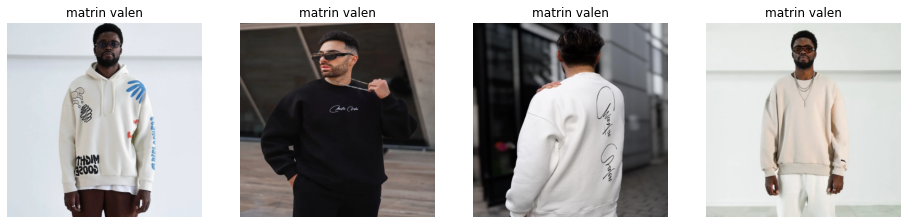

In [206]:
#!g2.1
import random
import matplotlib.pyplot as plt

num_samples = 4
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(num_samples):
    random_index = random.choice(range(len(dataset)))
    axs[i].imshow(dataset[random_index]['pixel_values'].permute(1, 2, 0).numpy() / 2 + 0.5)
    title = tokenizer.decode(dataset[random_index]['input_ids'].numpy().squeeze())
    title = title.replace("<|startoftext|>", "")
    title = title.replace("<|endoftext|>", "")
    title = title.strip()
    axs[i].set_title(title)
    axs[i].set_axis_off()

In [207]:
#!g2.1
import torch
train_dataloader = torch.utils.data.DataLoader(
    dataset, shuffle=True, batch_size=config.train_batch_size,drop_last = True
)

sample_image = next(iter(train_dataloader))

for k in sample_image:
    print(k, sample_image[k].shape)

pixel_values torch.Size([1, 3, 512, 512])
input_ids torch.Size([1, 15])


## 2. Загружаем основные компоненты диффузионной модели

1. Scheduler для создания шума
2. Текстовую модель для энкодинга текстов
3. VAE автоэнкодер
4. Готовую модель Stable Diffusion
5. Learning rate scheduler
6. Создадим промпты для валидации, а также функцию для отрисовки сгенерированных изображения


In [208]:
#!g2.1
from transformers import CLIPTextModel
from diffusers import AutoencoderKL, StableDiffusionPipeline, UNet2DConditionModel, DDPMScheduler

noise_scheduler = DDPMScheduler.from_pretrained(path, subfolder="scheduler")

text_encoder = CLIPTextModel.from_pretrained(
    path, subfolder="text_encoder",
)
vae = AutoencoderKL.from_pretrained(
    path, subfolder="vae",
)

In [209]:
#!g2.1
unet = UNet2DConditionModel.from_pretrained(
    path, subfolder="unet"
)

In [210]:
#!g2.1
import torch
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [211]:
#!g2.1
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(unet.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_train_epochs),
)

In [212]:
#!g2.1
validation_prompts = [ 'black hoodie with zipper by martin valen',
                         'beige hoodie with embroidery by martin valen',
                         'oversized white basic hoodie with ethnic design by martin valen',
                         'white hoodie with blue design by martin valen',
                         'black basic hoodie with white strips by martin valen',
                         'black hoodie with printed design by martin valen',
                         ]

In [213]:
#!g2.1
# ф-ция для вывода сгенерированных картинок

from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## 3. Обучение и валидация

Валидировать буду через оценку картинок. Для этого сгенерирую картинки с дизайнами до обучения и после. Посмотрим, будет ли модель делать более похожий дизайн.


In [214]:
#!g2.1
import math
import os


def evaluate(config, vae, text_encoder, tokenizer, unet, accelerator, weight_dtype):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    pipeline = StableDiffusionPipeline.from_pretrained(
        path,
        vae=accelerator.unwrap_model(vae),
        text_encoder=accelerator.unwrap_model(text_encoder),
        tokenizer=tokenizer,
        unet=accelerator.unwrap_model(unet),
        safety_checker=None,
        torch_dtype=weight_dtype,
    )
    pipeline = pipeline.to(device)
    pipeline.set_progress_bar_config(disable=True)

    generator = torch.Generator(device=device).manual_seed(config.seed)

    images = []
    for i in range(len(validation_prompts)):
        with torch.autocast("cuda"):
            image = pipeline(validation_prompts[i], num_inference_steps=20, generator=generator).images[0]

        images.append(image)
    del pipeline
    torch.cuda.empty_cache()

    return image_grid(images, rows = 1, cols = 6)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


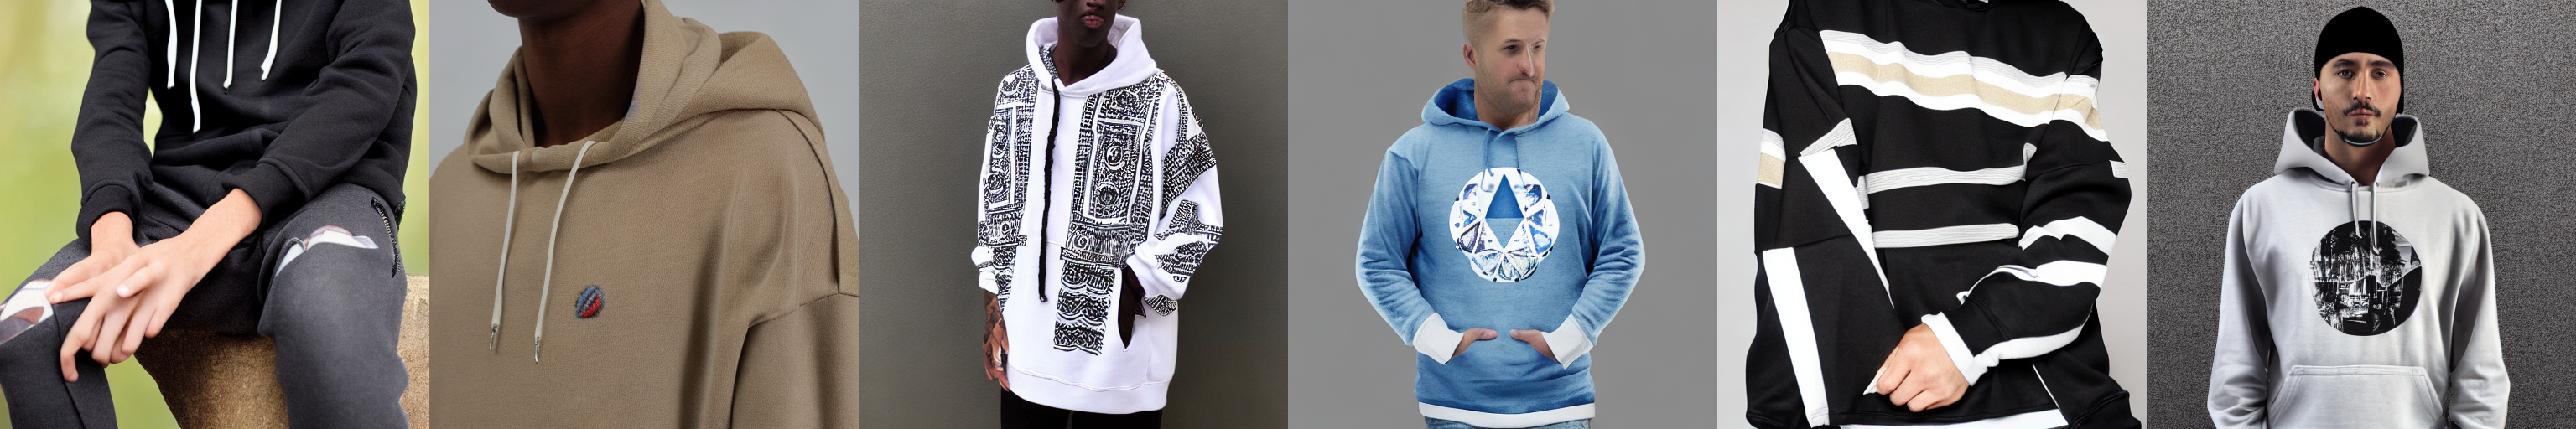

In [215]:
#!g2.1
from accelerate import Accelerator

evaluate(config, vae, text_encoder, tokenizer, unet, accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    ), weight_dtype = torch.float32)

Дизайн не особо интересный, но основной посыл бренда есть - одежда для брутальных мужчин. Посмотрим, что будет после finetune


In [216]:
#!g2.1
from accelerate import Accelerator
from tqdm.auto import tqdm
from pathlib import Path
import os
import torch.nn.functional as F

def train_loop(config, unet, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )

    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")
        
    

        # Prepare everything with our `accelerator`.
    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, lr_scheduler
    )
    
    weight_dtype = torch.float32
   

    # Move text_encode and vae to gpu and cast to weight_dtype
    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)
    
    text_encoder.to(device, dtype=weight_dtype)
    vae.to(device, dtype=weight_dtype)
    unet.to(device)
    unet.train()

    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / config.gradient_accumulation_steps)
    if config.max_train_steps is None:
        config.max_train_steps = config.num_train_epochs * num_update_steps_per_epoch
        overrode_max_train_steps = True

    # Afterwards we recalculate our number of training epochs
    config.num_train_epochs = math.ceil(config.max_train_steps / num_update_steps_per_epoch)

    total_batch_size = config.train_batch_size * accelerator.num_processes * config.gradient_accumulation_steps

    global_step = 0
    first_epoch = 0

    # Now you train the model
    for epoch in range(first_epoch, config.num_train_epochs):
        train_loss = 0.0
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):


            with accelerator.accumulate(unet):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(device).to(weight_dtype)).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)

                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=device)
                timesteps = timesteps.long()

                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"].to(device))[0]

                target = noise
   
                model_pred = unet(noisy_latents.to(device), timesteps, encoder_hidden_states).sample
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

                avg_loss = accelerator.gather(loss.repeat(config.train_batch_size)).mean()
                train_loss += avg_loss.item() / config.gradient_accumulation_steps

                # Backpropagate
                accelerator.backward(loss)
                accelerator.clip_grad_norm_(unet.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()


                progress_bar.update(1)
                global_step += 1
                accelerator.log({"train_loss": train_loss}, step=global_step)
                train_loss = 0.0

                logs = {"step_loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
                progress_bar.set_postfix(**logs)


                if global_step >= config.max_train_steps:
                    break


In [217]:
#!g2.1
from accelerate import notebook_launcher

args = (config, unet, noise_scheduler, optimizer, train_dataloader, lr_scheduler)


notebook_launcher(train_loop, args, num_processes=1, mixed_precision = 'no')

Launching training on one GPU.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


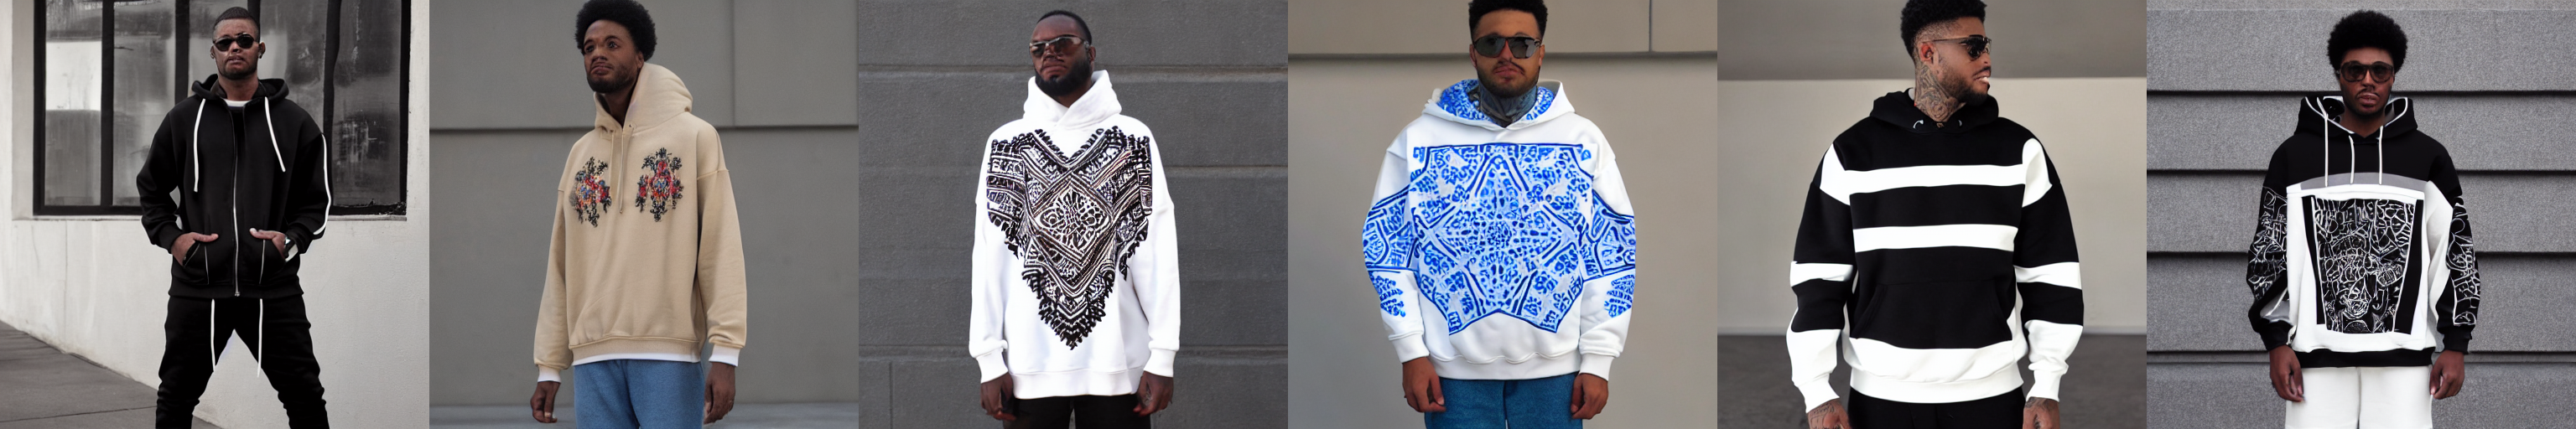

In [219]:
#!g2.1
evaluate(config, vae, text_encoder, tokenizer, unet, accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    ), weight_dtype = torch.float32)

Мне кажется дизайны стали лучше, не совсем похожие на референсные, но что-то новой и интересное добавилось.
